In [27]:
import torch
import torch.nn           as nn
import matplotlib.pyplot  as plt

from torch.optim          import Adam
from torchvision          import transforms
from torchvision.datasets import MNIST
from torch.utils.data     import DataLoader
from torchvision.utils    import make_grid

from model                import Generator, Discriminator
from tqdm.auto            import tqdm
from IPython.display      import clear_output

In [28]:
def plot_image(img_tensor, num_images=25, size=(1, 28, 28)):
    unflat_img = img_tensor.detach().cpu().view(-1, *size)
    grid       = make_grid(unflat_img[:num_images], nrow=5)
    
    plt.imshow(grid.permute(1, 2, 0).squeeze())
    plt.show()

In [29]:
def get_noise(n_samples, z_dim, device="cuda"):
    return torch.randn(n_samples, z_dim, device=device)

In [30]:
criterion    = nn.BCEWithLogitsLoss()
epochs       = 200
z_dim        = 64
display_step = 500
batch_size   = 128
lr           = 3e-4
device       = "cuda"

dataloader = DataLoader(
    MNIST('.', download=True, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True
)

In [31]:
gen     = Generator(z_dim).to(device)
g_optim = Adam(gen.parameters(), lr=lr)
disc    = Discriminator().to(device)
d_optim = Adam(disc.parameters(), lr=lr)

In [32]:
def get_disc_loss(gen, disc, criterion, real, n_imgs, z_dim, device):
    noise     = get_noise(n_imgs, z_dim, device)
    fake_img  = gen(noise).detach()
    fake_pred = disc(fake_img)
    fake_loss = criterion(fake_pred, torch.zeros_like(fake_pred))
    real_pred = disc(real)
    real_loss = criterion(real_pred, torch.ones_like(real_pred))
    
    return (fake_loss + real_loss) / 2


def get_gen_loss(gen, disc, criterion, n_imgs, z_dim, device):
    noise = get_noise(n_imgs, z_dim, device)
    fake_img = gen(noise)
    fake_pred = disc(fake_img)
    
    return criterion(fake_pred, torch.ones_like(fake_pred))


Step 93500: Generator loss: 3.3102709727287314, discriminator loss: 0.20313926245272165


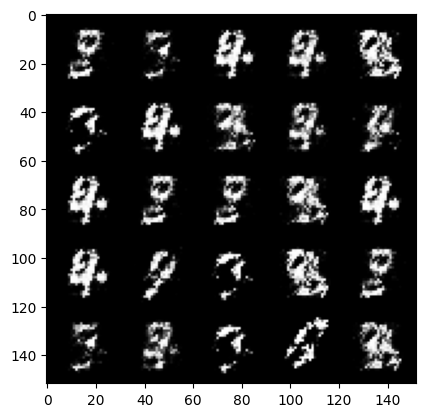

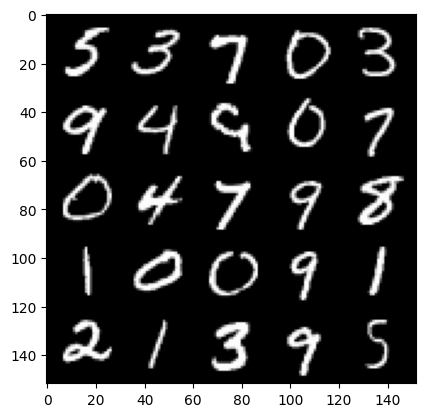

In [33]:
current_step = 0
mean_gen_loss = 0
mean_disc_loss = 0

for epoch in range(epochs):
    for real, _ in dataloader:
        clear_output(wait=True)
        current_batch_size = len(real)

        # Flatten the real imgs
        real = real.view(current_batch_size, -1).to(device)

        # Update discriminator
        d_optim.zero_grad()
        d_loss = get_disc_loss(gen, disc, criterion, real, current_batch_size, z_dim, device)
        d_loss.backward(retain_graph=True)
        d_optim.step()

        # Keep track of generator weights
        old_gen_weights = gen.generator[0][0].weight.detach().clone()

        # Update generator
        g_optim.zero_grad()
        g_loss = get_gen_loss(gen, disc, criterion, current_batch_size, z_dim, device)
        g_loss.backward()
        g_optim.step()

        # Make sure generator weights are being updated
        assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
        assert torch.any(gen.generator[0][0].weight.detach().clone() != old_gen_weights)

        # Keep track of avg losses
        mean_disc_loss += d_loss.item() / display_step
        mean_gen_loss  += g_loss.item() / display_step

        if current_step % display_step == 0 and current_step > 0:
            print(f"Step {current_step}: Generator loss: {mean_gen_loss}, discriminator loss: {mean_disc_loss}")
            fake_noise = get_noise(current_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            plot_image(fake)
            plot_image(real)
            mean_gen_loss = 0
            mean_disc_loss = 0

        current_step += 1

